In [38]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score

# Load feature selection results
results_df = pd.read_csv('../feature_selection/sick_vs_sick/sick_sick_feature_genes.csv')

# Set number of selected genes per comparison
num_selected_genes = 1000  # Can be tuned for optimal performance

# Sort and select top genes PER comparison
comparison_gene_map = {
    comparison: results_df[results_df['Comparison'] == comparison]
    .sort_values('P_value')
    .head(num_selected_genes)['Gene'].unique()
    for comparison in results_df['Comparison'].unique()
}

In [39]:
comparison_gene_map

{'PBC vs Rest': array(['C11orf73', 'HMGN3', 'TCP11L2', 'SLC27A1', 'IL7R', 'RAB9B',
        'MGARP', 'ATP1A1', 'USP22', 'RAC3', 'PMM2', 'HP', 'FHL1', 'PRMT10',
        'KAAG1', 'IL33', 'HIST1H2AB', 'CCT8', 'WDR52', 'BEX4', 'NEFH',
        'CASK', 'MTX1', 'MFSD6', 'AMOTL1', 'LTN1', 'PPIL4', 'C20orf26',
        'DYNC2LI1', 'UBE2J1', 'HIST1H3B', 'KLHL4', 'MYL2', 'PCDH18',
        'NDUFB9', 'FTO', 'L3MBTL2', 'CALCRL', 'PARP6', 'CCDC107',
        'ARFGEF2', 'GPATCH8', 'RRP36', 'STAT5A', 'NUDT11', 'UBQLN2',
        'ZKSCAN8', 'COL1A2', 'RBM15B', 'HOXD10', 'RPL7A', 'ICOS', 'MMP2',
        'METTL21D', 'IRAK3', 'EXOSC1', 'SNIP1', 'GGT6', 'GTF2F1', 'KLHL30',
        'RAB23', 'CLEC2L', 'DPY30', 'DIAPH2', 'CSRNP1', 'PPP2R5B',
        'SERHL2', 'ZBTB4', 'ZNF665', 'BDH1', 'ERC1', 'ANO2', 'DISP1',
        'MED22', 'RPGRIP1L', 'ABCA6', 'TATDN1', 'PRICKLE1', 'MYCBP',
        'AHSA2', 'ZBTB9', 'SLC10A3', 'ALX1', 'HSD17B8', 'PC', 'ELAVL3',
        'ZDHHC16', 'RNPS1', 'TTC38', 'FASTKD2', 'PZP', 'MAPRE3', '

In [40]:
# Load the gene expression data
gene_matrix = pd.read_csv(
    '/Users/hilleldravish/Library/CloudStorage/GoogleDrive-darvish.hillel@mail.huji.ac.il/My Drive/CBIO-HACK/Data/CleanUp/cleaned_llb_matrix.csv'
)

# Balance dataset across diagnosis classes
def balance_classes(df, label_col='Diagnosis'):
    groups = df.groupby(label_col)
    min_size = groups.size().min()
    downsampled_groups = [
        group.sample(n=min_size, random_state=12, replace=False) if len(group) > min_size else group
        for _, group in groups
    ]
    return pd.concat(downsampled_groups).sample(frac=1, random_state=8).reset_index(drop=True)

gene_matrix = balance_classes(gene_matrix)

In [41]:
# Extract labels and features
labels = gene_matrix['Diagnosis']
all_selected_genes = set(np.concatenate(list(comparison_gene_map.values())))  # Unique selected genes
features = gene_matrix[list(all_selected_genes)]

# Ensure all diagnoses are present in both train and test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, stratify=labels, random_state=8)

# Train models for each comparison
models = {}

In [42]:
y_train

34     AIH
14     PBC
8      PBC
4      PBC
32    MASH
38     AIH
33    MASH
26     AIH
37    MASH
21    MASH
12     PBC
6      PBC
22     AIH
9     MASH
2      AIH
36     AIH
35     PBC
15     AIH
24     AIH
23    MASH
25    MASH
19     AIH
7      PBC
0     MASH
3      PBC
31     PBC
18    MASH
Name: Diagnosis, dtype: object

In [43]:
y_test

27     PBC
11    MASH
30    MASH
16     AIH
17     AIH
5      AIH
28     AIH
29     PBC
13     PBC
20    MASH
10     PBC
1     MASH
Name: Diagnosis, dtype: object

In [44]:
import tqdm

# Function to train one-vs-rest models
def train_models(comparison_gene_map, X_train, y_train):
    models = {}

    for comparison, genes in comparison_gene_map.items():
        target_class = comparison.split(' vs ')[0]
        subyTrain = np.where(y_train == target_class, 1, 0)

        model = LogisticRegression(max_iter=5000)
        model.fit(X_train[genes], subyTrain)

        models[comparison] = model

    return models


# Function to perform ensemble classification
def ensemble_predict(models, comparison_gene_map, X_test):
    final_predictions = []

    for idx in range(X_test.shape[0]):
        sample = X_test.iloc[idx]
        max_prob = -np.inf
        selected_prediction = None

        for comparison, model in models.items():
            genes = comparison_gene_map[comparison]
            sample_genes = sample[genes].to_frame().T

            prob = model.predict_proba(sample_genes)[0][1]

            if prob > max_prob:
                max_prob = prob
                selected_prediction = comparison.split(' vs ')[0]

        final_predictions.append(selected_prediction)

    return final_predictions


# Feature impact on accuracy
feature_counts = np.arange(1, num_selected_genes + 1, 1)
accuracies = []
f1_scores = []

for num_features in tqdm.tqdm(feature_counts):
    # Create new gene selection for this feature count
    subset_comparison_gene_map = {
        comp: genes[:num_features] for comp, genes in comparison_gene_map.items()
    }

    # Train models with current number of features
    models = train_models(subset_comparison_gene_map, X_train, y_train)

    # Get predictions
    final_predictions = ensemble_predict(models, subset_comparison_gene_map, X_test)

    # Evaluate performance
    acc = accuracy_score(y_test, final_predictions)
    f1 = f1_score(y_test, final_predictions, average='weighted')

    accuracies.append(acc)
    f1_scores.append(f1)


100%|██████████| 1000/1000 [04:05<00:00,  4.08it/s]


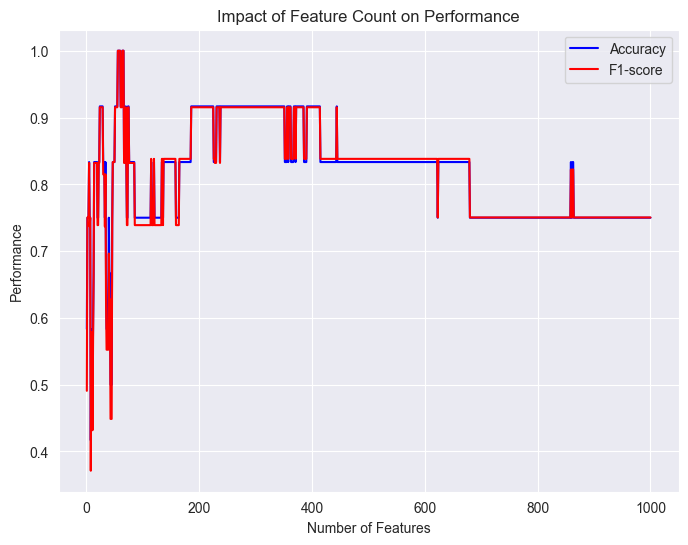

<Figure size 640x480 with 0 Axes>

In [45]:
# Plot accuracy vs. feature count
plt.figure(figsize=(8, 6))
plt.plot(feature_counts, accuracies, linestyle='-', color='b', label='Accuracy')
plt.plot(feature_counts, f1_scores, linestyle='-', color='r', label='F1-score')
plt.xlabel("Number of Features")
plt.ylabel("Performance")
plt.title("Impact of Feature Count on Performance")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('accur_f1_liver_ds.png')

In [46]:

# Find the best number of features
best_feature_idx = np.argmax(accuracies)
best_num_features = feature_counts[best_feature_idx]
print(f"Best number of features: {best_num_features} with Accuracy {accuracies[best_feature_idx]:.2f}")

# Retrain models with best feature count
best_comparison_gene_map = {
    comp: genes[:best_num_features] for comp, genes in comparison_gene_map.items()
}
best_models = train_models(best_comparison_gene_map, X_train, y_train)

# Get final predictions
final_predictions = ensemble_predict(best_models, best_comparison_gene_map, X_test)

Best number of features: 56 with Accuracy 1.00


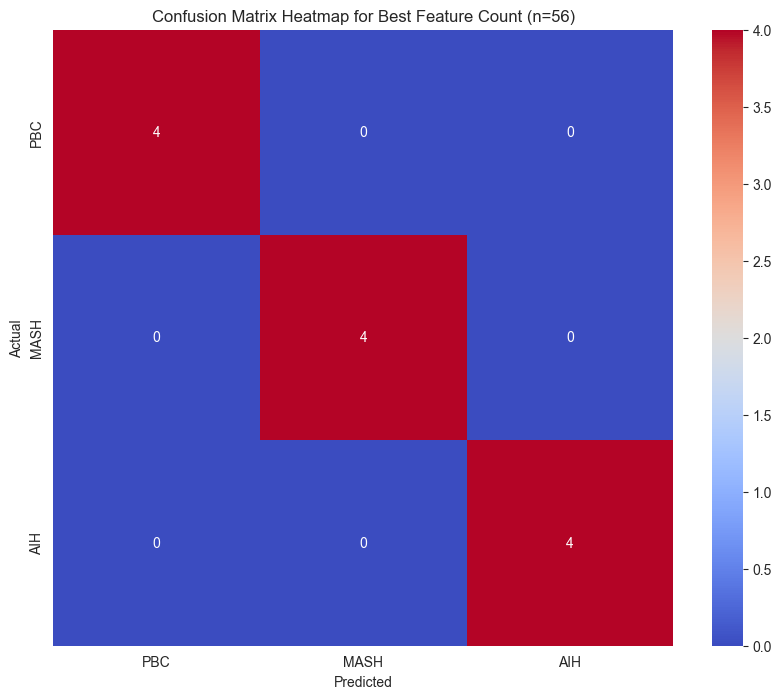

<Figure size 640x480 with 0 Axes>

In [50]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, final_predictions, labels=y_test.unique())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=y_test.unique(), yticklabels=y_test.unique())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap for Best Feature Count (n=56)")
plt.show()
plt.savefig('heatmap_liver_ds.png')